# Calibração

Este notebook mostra como foi determinada a posição do sensor no smartphone a partir de medidas do campo magnético produzido por um imã.

In [1]:
# importa os pacotes usados neste Jupyter Notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#### Coordenadas das medidas

In [2]:
# carrega as informações do arquivo 'calibracao.txt'
calibracao = np.genfromtxt(
    'calibracao.txt', 
    dtype=([('Cf', '<i8'), ('Lado', 'S1'), ('X', '<f8'), ('Y', '<f8')]))

In [3]:
lados = [b'E', b'T', b'D', b'B']

# shift_x e shift_y definem as correções que devem ser 
# aplicadas às coordenadas X e Y das medidas. As correções
# incluem a distância entre o centro do imã e a borda da 
# folha de papel sobre a qual o smartphone foi fixado.
shift_x = [-1.3, 0, 1.3, 0]
shift_y = [0, 1.3, 0, -1.3]

In [4]:
# aplicação das correções definidas acima
X = []
Y = []
for lado, sx, sy in zip(lados, shift_x, shift_y):
    mask = (calibracao['Lado'] == lado)
    X.append(calibracao['X'][mask] + sx)
    Y.append(calibracao['Y'][mask] + sy)
X = np.hstack(X)
Y = np.hstack(Y)

#### Medidas do campo

In [5]:
Bx = [] # componente x
By = [] # componente y
Bz = [] # componente z
sx = [] # desvio padrão da componente x
sy = [] # desvio padrão da componente y
sz = [] # desvio padrão da componente z

# o 'for' abaixo itera sobre os arquivos 'CfXXX.csv',
# extrai as medidas das compoentes x, y, z, calcula
# os valores médios e seus respectivos desvios padrão
for i in calibracao['Cf']:
    filename = 'Cf{}.csv'.format(i)
    B = np.genfromtxt(filename, delimiter=',', usecols=(1,2,3), skip_header=1)
    B_mean = np.mean(B, axis=0)
    B_std  = np.std(B, axis=0)
    Bx.append(B_mean[0])
    By.append(B_mean[1])
    Bz.append(B_mean[2])
    sx.append(B_std[0])
    sy.append(B_std[1])
    sz.append(B_std[2])

# converte os valores em numpy arrays (vetores do Numpy)
Bx = np.array(Bx)
By = np.array(By)
Bz = np.array(Bz)
sx = np.array(sx)
sy = np.array(sy)
sz = np.array(sz)

In [6]:
Bx0 = []
By0 = []
Bz0 = []
sx0 = []
sy0 = []
sz0 = []
for i in range(4):
    filename = 'Sf{}.csv'.format(i)
    B = np.genfromtxt(filename, delimiter=',', usecols=(1,2,3), skip_header=1)
    B_mean = np.mean(B, axis=0)
    B_std = np.std(B, axis=0)
    Bx0.append(B_mean[0])
    By0.append(B_mean[1])
    Bz0.append(B_mean[2])
    sx0.append(B_std[0])
    sy0.append(B_std[1])
    sz0.append(B_std[2])
Bx0 = np.median(np.array(Bx0))
By0 = np.median(np.array(By0))
Bz0 = np.median(np.array(Bz0))
sx0 = np.median(np.array(sx0))
sy0 = np.median(np.array(sy0))
sz0 = np.median(np.array(sz0))

In [7]:
print(Bx0, By0, Bz0)

-14.280906414133373 17.46242623262897 10.649432197994589


In [8]:
Bx = Bx - Bx0
By = By - By0
Bz = Bz - Bz0

In [9]:
Bt = np.sqrt(Bx**2 + By**2 + Bz**2)

In [10]:
st = np.sqrt(
    (Bx**2)*(sx**2 + sx0**2) + (By**2)*(sy**2 + sy0**2) + (Bz**2)*(sz**2 + sz0**2)
    )/Bt

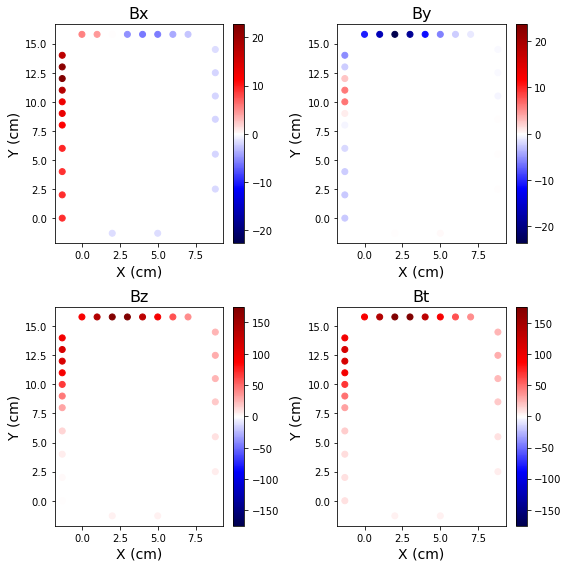

In [11]:
dados = [Bx, By, Bz, Bt]
title = ['Bx', 'By', 'Bz', 'Bt']
ranges = [np.max(np.abs(Bx)),
          np.max(np.abs(By)),
          np.max(np.abs(Bz)),
          np.max(np.abs(Bt))]

plt.figure(figsize=(8,8))

for index in range(1,5):

    plt.subplot(2,2,index)
    plt.title(title[index-1], fontsize=16)
    plt.scatter(X, Y, c=dados[index-1], 
                cmap='seismic', vmin=-ranges[index-1], vmax=ranges[index-1])
    plt.colorbar()
    plt.xlabel('X (cm)', fontsize = 14)
    plt.ylabel('Y (cm)', fontsize = 14)
plt.tight_layout()
plt.show()

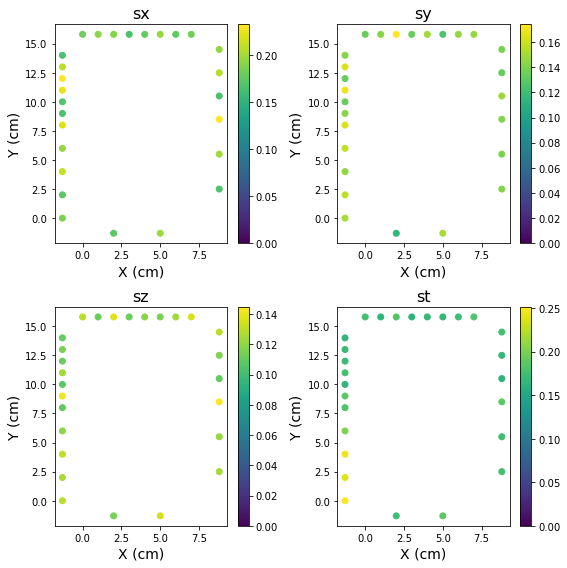

In [12]:
dados = [sx, sy, sz, st]
title = ['sx', 'sy', 'sz', 'st']
ranges = [np.max(sx),
          np.max(sy),
          np.max(sz),
          np.max(st)]

plt.figure(figsize=(8,8))

for index in range(1,5):

    plt.subplot(2,2,index)
    plt.title(title[index-1], fontsize=16)
    plt.scatter(X, Y, c=dados[index-1], 
                cmap='viridis', vmin=0, vmax=ranges[index-1])
    plt.colorbar()
    plt.xlabel('X (cm)', fontsize = 14)
    plt.ylabel('Y (cm)', fontsize = 14)
plt.tight_layout()
plt.show()

#### Determinação da posição do sensor

In [13]:
def erro_quadratico_medio(p, *args):
    X, Y, Bx, By, Bz = args
    N = X.size
    assert X.ndim == Y.ndim == 1, 'X e Y devem ser vetores'
    assert Bx.ndim == By.ndim == Bz.ndim == 1, 'Bx, By e Bz devem ser vetores'
    assert X.size == Y.size, 'X e Y devem ter o mesmo num de elementos'
    assert Bx.size == By.size == Bz.size == N, 'Bx, By e Bz devem ter o mesmo n de elmentos'
    
    # Dados preditos pelo modelo de dipolo
    Bx_calculado, By_calculado, Bz_calculado = dipolo(p, X, Y)
    
    # residuos entre as componentes medidas e calculadas
    residuos_x = Bx - Bx_calculado
    residuos_y = By - By_calculado
    residuos_z = Bz - Bz_calculado
    
    # soma dos erros quadráticos médios para cada componente 
    resultado  = np.sum(residuos_x*residuos_x)/N
    resultado += np.sum(residuos_y*residuos_y)/N
    resultado += np.sum(residuos_z*residuos_z)/N
    
    return resultado

In [14]:
def grade_erro_quadratico_medio(mz, X0_min, X0_max, Y0_min, Y0_max, Nx, Ny, *args):
    assert isinstance(Nx, int) and (Nx > 0), 'Nx deve ser um inteiro positivo'
    assert isinstance(Ny, int) and (Ny > 0), 'Ny deve ser um inteiro positivo'
    assert np.isscalar(mz), 'mz deve ser um escalar'
    assert np.isscalar(X0_min), 'X0_min deve ser um escalar'
    assert np.isscalar(Y0_min), 'Y0_min deve ser um escalar'
    assert np.isscalar(X0_max), 'X0_max deve ser um escalar'
    assert np.isscalar(Y0_max), 'Y0_max deve ser um escalar'
    assert X0_min < X0_max, 'X0_min deve ser menor que X0_max'
    assert Y0_min < Y0_max, 'Y0_min deve ser menor que Y0_max'
    
    X0 = np.linspace(X0_min, X0_max, Nx)
    Y0 = np.linspace(Y0_min, Y0_max, Ny)
    X0, Y0 = np.meshgrid(X0, Y0)
    X0 = X0.ravel()
    Y0 = Y0.ravel()
    
    grade = []
    for X0i, Y0i in zip(X0, Y0):
        p = np.array([X0i, Y0i, mz])
        grade.append(erro_quadratico_medio(p, *args))
    grade = np.array(grade).reshape((Nx, Ny))
    X0 = np.reshape(X0, (Nx, Ny))
    Y0 = np.reshape(Y0, (Nx, Ny))
    
    return X0, Y0, grade

In [47]:
def dipolo(p, X, Y):
    assert X.ndim == Y.ndim == p.ndim == 1, 'X, Y e p devem ser vetores' 
    assert X.size == Y.size, 'X e Y devem ter o mesmo num de elementos'
    assert p.size == 3, 'p deve ter 3 elementos'
    
    X0, Y0, mz = p
    Z0 = 2.25 # 1.95 cm (altura do vidro) + 3 mm (metade da espessura do smartphone)
    Z = 0.1 # metade da espessura do ima (em cm)
    #Z0 = 0.5
    #Z = 0
    
    # diferencas entre as coordenadas (em metros)
    DX = (X0 - X)*0.01
    DY = (Y0 - Y)*0.01
    DZ = (Z0 - Z)*0.01
    
    # distancias
    r = np.sqrt(DX**2 + DY**2 + DZ**2)
    r3 = r*r*r
    r5 = r3*r*r
    
    # Constante de proporcionalidade igual a u0/4pi * 10^6,
    # em que u0 é a permeabilidade magnética no vácuo. A razao
    # u0/4pi = 10^-7. O fator 10^6 converte Tesla para micro Tesla.
    constante = 0.1
    
    # componentes do campo produzido pelo modelo de dipolo
    Bx_calculado = constante*(3*DX*DZ/r5)*mz
    By_calculado = constante*(3*DY*DZ/r5)*mz
    Bz_calculado = constante*(3*DZ*DZ/r5 - 1/r3)*mz
    
    return Bx_calculado, By_calculado, Bz_calculado

In [48]:
X0_grade, Y0_grade, grade = grade_erro_quadratico_medio(
    -0.05, 2.3, 2.7, 12.3, 12.7, 50, 50, *(X, Y, Bx, By, Bz)
    )

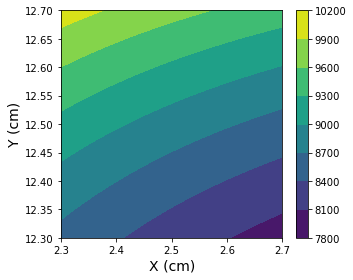

In [49]:
plt.figure(figsize=(5,4))
plt.contourf(X0_grade, Y0_grade, grade, cmap='viridis')
plt.colorbar()
plt.xlabel('X (cm)', fontsize = 14)
plt.ylabel('Y (cm)', fontsize = 14)
plt.tight_layout()
plt.show()